In [1]:
%matplotlib inline
import keras
import keras.backend     as K
import matplotlib.pyplot as plt
import numpy             as np

from keras.models         import Sequential
from keras.layers         import Convolution2D
from keras.layers         import MaxPooling2D
from keras.layers         import Activation
from keras.layers         import Dense
from keras.layers         import Flatten
from keras.layers         import Reshape
from keras.layers         import UpSampling2D
from keras.optimizers     import Adam
from keras.utils.np_utils import to_categorical
from keras.datasets       import mnist

path_to_fashion_mnist = '../../datasets/fashion-mnist/'

import sys
sys.path.insert(0, path_to_fashion_mnist)
from utils import mnist_reader

Using TensorFlow backend.


In [2]:
anomalies_number = 400
encoding_size    = 200
batch_size       = 64

# Dataset creation

## Dataset loading

First, we load the fashion MNIST dataset.

In [3]:
X_train_fashion, _ = mnist_reader.load_mnist(path_to_fashion_mnist + 'data/fashion', kind = 'train')
X_test_fashion, _  = mnist_reader.load_mnist(path_to_fashion_mnist + 'data/fashion', kind = 't10k')
X_fashion          = np.concatenate((X_train_fashion, X_test_fashion)).reshape(-1, 28, 28, 1)

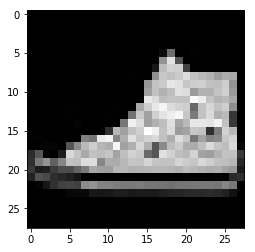

In [4]:
plt.imshow(X_fashion[35].squeeze(), cmap = 'gray')

Then we load the digit MNIST dataset.

In [5]:
(X_train_digits, _), (X_test_digits, _) = mnist.load_data()
X_digits                                = np.concatenate((X_train_digits, X_test_digits)).reshape(-1, 28, 28, 1)

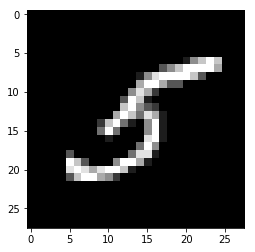

In [6]:
plt.imshow(X_digits[35].squeeze(), cmap = 'gray')

## Anomaly dataset creation 

Now, we extract `anomaly_number` images from the fashion MNIST dataset. Then, we create a big dataset with all the MNIST digits and these `anomaly number` images.

In [7]:
anomalies = np.random.permutation(X_fashion)[:400]

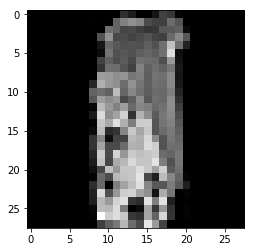

In [8]:
plt.imshow(anomalies[39].squeeze(), cmap = 'gray')

In [9]:
X = np.concatenate((X_digits, anomalies))
X = np.random.permutation(X)
X = (X - X.mean()) / X.std()

# Replicator network

The intuition that I have on replicator network is that they are autoencoders (a highly specialized compressor and decompressor) trained on the whole dataset. The idea is that the "usual" will be handled quite well by our autoencoder in the sense that the structure of the data will be well understood, i.e. the image produced by encoding and then decoding will be very close to the original one. To discover anomalies in our dataset, we will try to look for images that differ a lot from their compressed and decompressed counterparts.
Let's first build and train this autoencoder.

In [10]:
encoder = Sequential([
    Convolution2D(64, (3, 3), padding = 'same', input_shape = (28, 28, 1), activation = 'relu'),
    Convolution2D(64, (3, 3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(encoding_size, activation = 'tanh'),
])

In [11]:
decoder = Sequential([
    Dense(49, input_shape = (encoding_size,), activation = 'relu'),
    Reshape((7, 7, 1)),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    UpSampling2D(),
    Convolution2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Convolution2D(64, (3, 3), padding = 'same', activation = 'relu'),
    UpSampling2D(),
    Convolution2D(1, (3, 3), padding = 'same')
])

In [12]:
autoencoder = Sequential([
    encoder,
    decoder
])
autoencoder.compile(optimizer = Adam(1e-4), loss = 'mse')

In [13]:
fit_params = {
    'x'               : X,
    'y'               : X,
    'batch_size'      : batch_size,
    'epochs'          : 30,
    'validation_split': 0.15
}

In [14]:
autoencoder.fit(**fit_params)

Train on 59840 samples, validate on 10560 samples
Epoch 1/30
59840/59840 [==============================] - 129s - loss: 0.2782 - val_loss: 0.1463
Epoch 2/30
59840/59840 [==============================] - 130s - loss: 0.1207 - val_loss: 0.1034
Epoch 3/30
59840/59840 [==============================] - 128s - loss: 0.0935 - val_loss: 0.0869
Epoch 4/30
59840/59840 [==============================] - 126s - loss: 0.0806 - val_loss: 0.0758
Epoch 5/30
59840/59840 [==============================] - 128s - loss: 0.0729 - val_loss: 0.0702
Epoch 6/30
59840/59840 [==============================] - 126s - loss: 0.0671 - val_loss: 0.0653
Epoch 7/30
59840/59840 [==============================] - 128s - loss: 0.0628 - val_loss: 0.0616
Epoch 8/30
59840/59840 [==============================] - 130s - loss: 0.0594 - val_loss: 0.0601
Epoch 9/30
59840/59840 [==============================] - 129s - loss: 0.0566 - val_loss: 0.0556
Epoch 10/30
59840/59840 [==============================] - 128s - loss: 0.054

Now that the network is trained, we want to get an idea of the quality of compression on "normal" data and on "anomalies".

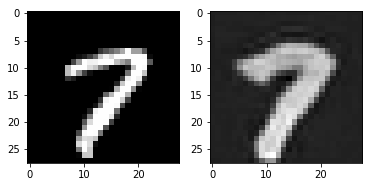

In [15]:
digit_img = np.expand_dims(X_digits[2929], 0)
digit_img_ = autoencoder.predict(digit_img)
plt.subplot(1, 2, 1)
plt.imshow(digit_img[0].squeeze(), cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(digit_img_[0].squeeze(), cmap = 'gray')

We can see that the digit images are recovered pretty well, that is a good first step for what we are trying to implement.

Now let's do the same thing with images from the fashion dataset.

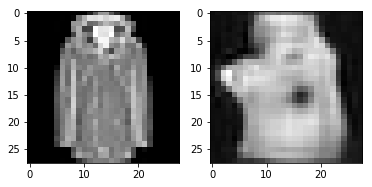

In [16]:
fashion_img = np.expand_dims(X_fashion[22], 0)
fashion_img_ = autoencoder.predict(fashion_img)
plt.subplot(1, 2, 1)
plt.imshow(fashion_img[0].squeeze(), cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(fashion_img_[0].squeeze(), cmap = 'gray')

The quality of the recovered image is terrible, which is really good for our usecase. Since these images are very different from the "normal" ones, the autoencoder haven't manage to capture their structures. We can hope that anomalous images will have a reconstruction loss much higher than normal ones.

In [17]:
autoencoder.save_weights('../models/autoencoder_%dD.h5' % encoding_size)

In [18]:
autoencoder.load_weights('../models/autoencoder_%dD.h5' % encoding_size)

In [19]:
X_ = autoencoder.predict(X, batch_size = 2 * batch_size)

In [20]:
pixel_mse = ((X - X_) ** 2).squeeze()
image_mse = pixel_mse.reshape(pixel_mse.shape[0], -1).mean(axis = 1)

(array([  3.83560000e+04,   2.74870000e+04,   3.54500000e+03,
          6.03000000e+02,   1.87000000e+02,   9.70000000e+01,
          4.70000000e+01,   3.50000000e+01,   1.80000000e+01,
          4.00000000e+00,   1.00000000e+01,   4.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]),
 array([ 0.003823  ,  0.03534696,  0.06687091,  0.09839487,  0.12991883,
         0.16144278,  0.19296674,  0.22449069,  0.25601465,  0.28753861,
         0.31906256,  0.35058652,  0.38211047,  0.41363443,  0.44515838,
         0.47668234,  0.5082063 ,  0.53973025,  0.57125421,  0.60277816,
         0.63430212,  0.66582608,  0.69735003,  0.72887399,  0.76039794,
         0.79

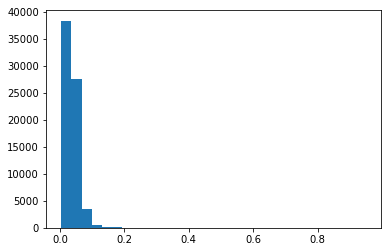

In [21]:
plt.hist(image_mse, bins = 30)

Now let's visualize some of the images that have the highest reconstruction loss. 

What we hope is that the autoencoder has failed to reconstruct these images because their structure did not correspond to most of the other in the dataset. Another way to phrase it is that we hope that highly unusual pictures (anomalies) will have a high reconstruction loss.

In [22]:
reconstruction_loss_sort_idx = image_mse.argsort()

In [23]:
def create_visualization(X, n, loss_idx):
    plt.figure(figsize = (15, 15))
    X_high_loss = X[loss_idx[-n**2:]]
    for i in range(n):
        for j in range(n):
            idx = i * n + j
            plt.subplot(n, n, idx + 1)
            img = X_high_loss[idx].squeeze()
            plt.imshow(img, cmap = 'gray')
            plt.axis('off')

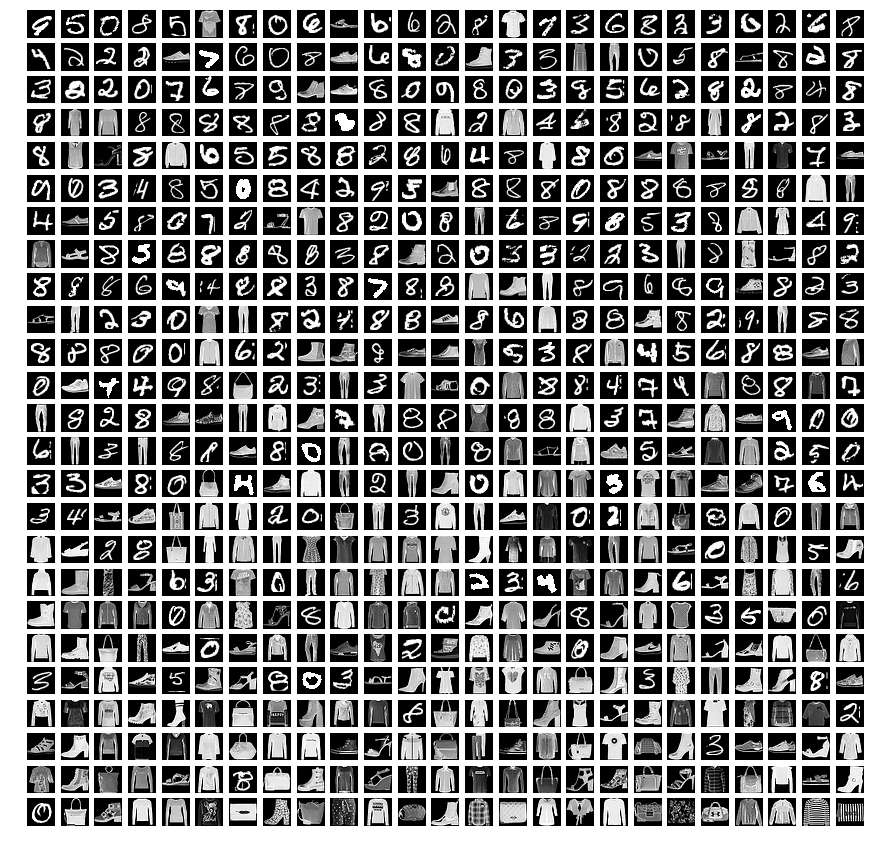

In [24]:
create_visualization(X, 25, reconstruction_loss_sort_idx)

As we hoped, the images that the network had trouble to reconstruct are mostly fashion MNIST images and classical MNIST digits written in a highly unusual way. The most interesting fact about this approach is that at no point during this notebook, we have explained to the network what normal and abnormal data should be, it automatically detected outliers among our images.